In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from scipy import interpolate
from sklearn.calibration import LabelEncoder
color = sns.color_palette()

In [16]:
train_origin=pd.read_csv("data/round2_train.txt",sep=" ")

np.random.seed(0)  
# 按照列的比例随机抽取数据  
train_sample_ratio = 0.01  # 设置抽样比例为1%  
train = train_origin.sample(frac=train_sample_ratio, random_state=0)  
  

In [17]:
test_a_origin=pd.read_csv("data/round2_ijcai_18_test_a_20180425.txt",sep=" ")
test_b_origin=pd.read_csv("data/round2_ijcai_18_test_b_20180510.txt",sep=" ")

np.random.seed(0)  
# 按照列的比例随机抽取数据  
test_a_sample_ratio = 0.01  # 设置抽样比例为1%  
test_a = test_a_origin.sample(frac=test_a_sample_ratio, random_state=0)  

# 按照列的比例随机抽取数据  
test_b_sample_ratio = 0.01  # 设置抽样比例为1%  
test_b = test_b_origin.sample(frac=test_b_sample_ratio, random_state=0)  

In [18]:
test = test_a.append(test_b)
data = pd.concat([train, test])

/var/folders/hv/0r6f95ls1ss09znhzxqsj0nr0000gn/T/ipykernel_22235/1659890164.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test_a.append(test_b)


In [19]:
#原始特征
data.columns.tolist()

['instance_id',
 'item_id',
 'item_category_list',
 'item_property_list',
 'item_brand_id',
 'item_city_id',
 'item_price_level',
 'item_sales_level',
 'item_collected_level',
 'item_pv_level',
 'user_id',
 'user_gender_id',
 'user_age_level',
 'user_occupation_id',
 'user_star_level',
 'context_id',
 'context_timestamp',
 'context_page_id',
 'predict_category_property',
 'shop_id',
 'shop_review_num_level',
 'shop_review_positive_rate',
 'shop_star_level',
 'shop_score_service',
 'shop_score_delivery',
 'shop_score_description',
 'is_trade']

In [20]:
#初始维度
data.shape

(121617, 27)

In [21]:
#时间数据处理
data['time'] = pd.to_datetime(data.context_timestamp, unit='s')
data['time'] = data['time'].apply(lambda x: x + datetime.timedelta(hours=8)) # 考虑时区，这里我们假设是北京时间（UTC+8）  
data['day'] = data['time'].apply(lambda x: int(str(x)[8:10]))
data['hour'] = data['time'].apply(lambda x: int(str(x)[11:13]))   
data['minute'] =  data['time'].apply(lambda x: int(str(x)[14:16]))


In [22]:
#对一天中的不同时间段进行分类或分析。例如，您可能想要跟踪用户在不同时间段内的活动情况，或者根据时间段对某些数据进行分类
def map_hour(s):
    if s < 6:
        return 1
    elif s < 12:
        return 2
    elif s < 18:
        return 3
    else:
        return 4

In [23]:
data['maphour'] = data['hour'].map(map_hour)
data['mapmin'] = data['minute'] % 15 + 1

In [24]:
data_item_category = data.item_category_list.str.split(';', expand=True).add_prefix('item_category_')

for i in range(3):
    data['item_category_'+str(i)] =  data_item_category['item_category_'+str(i)]     
del data['item_category_0']
data['item_category_1'] = data['item_category_1'].apply(int)
data['item_category_2'].fillna(value=0, inplace=True)
data['item_category_2'] = data['item_category_2'].apply(int)

In [25]:
label = ['item_category_1',  'item_category_2', 'context_id',  'item_brand_id', 'item_city_id', 'item_id', 'user_id', 'shop_id']
    
short_label = ['context_page_id', 'shop_star_level', 'user_age_level', 'user_occupation_id', 'user_star_level']

score_label = ['shop_score_service', 'shop_review_positive_rate', 'shop_score_delivery', 'shop_score_description']
    
for col in label:
    col_encoder = LabelEncoder()
    col_encoder.fit(data[col])
    data[col] = col_encoder.transform(data[col])

for col in short_label:
    col_encoder = LabelEncoder()
    col_encoder.fit(data[col])
    data[col] = col_encoder.transform(data[col])

for col in score_label:
    data[col] = round(data[col], 3)

In [26]:
path = './data/'
# 写入
len = train.shape[0]
train_all = data[:len]
test_all = data[len:]


train_all.to_csv(path+'train_all.csv', index=False)
test_all.to_csv(path+'test_all.csv', index=False)



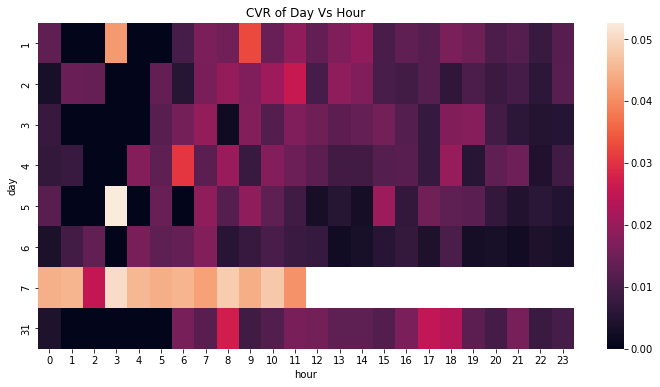

In [27]:
grouped_df = train_all.groupby(["day", "hour"])["is_trade"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'is_trade')
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("CVR of Day Vs Hour")
plt.show()

In [28]:
# # 写文件
# def write_xlsx(df,path, sheetName):
#     writer = pd.ExcelWriter(path, engine='openpyxl',mode='a', if_sheet_exists="overlay")
#     df.to_excel(writer, sheet_name=sheetName)
#     writer.close()
# # 写入同一个文件三张表
# path = '../data_all.xlsx'
# pd.DataFrame().to_excel(path,sheet_name='total') # 先创建文件
# write_xlsx(train,path,'train')
# write_xlsx(test_a, path,'test_a')
# write_xlsx(test_b,path,'test_b')